### MSE Variance Budget Analysis

### MSE Variance Equation:

The MSE variance budget equation is:

$$
\frac{\partial}{\partial t} \langle MSE^2 \rangle + \nabla \cdot \langle F \rangle = Q_{\text{LW}} + Q_{\text{SW}} + Q_{\text{SHF}} + Q_{\text{LHF}} + Q_{\text{div}}
$$

Where:
- $\frac{\partial}{\partial t} \langle MSE^2 \rangle$ is the rate of change of the MSE variance.
- $\nabla \cdot \langle F \rangle$ represents the divergence of the flux.

and:

- \( $Q_{\text{LW}}$ \) is the longwave heating,
- \( $Q_{\text{SW}}$ \) is the shortwave heating,
- \( $Q_{\text{SHF}}$ \) is the surface sensible heat flux,
- \( $Q_{\text{LHF}}$ \) is the surface latent heat flux,
- \( $Q_{\text{div}}$ \) is the divergence term, which accounts for the advection of MSE.

For a perturbation-based analysis, we can subtract the mean to get the deviations from the mean for each of these components and analyze their contributions. Here's a step-by-step approach based on the variables you have:

### Steps for MSE Budget Analysis:

1. **Compute MSE Perturbation**:
    
    Subtract the time mean of the MSE to obtain the perturbation:
    $$
    \text{MSE}' = \text{MSE} - \langle \text{MSE} \rangle
    $$

2. **Compute the Fluxes and Divergence Terms**:
    
    - Compute the **Longwave** and **Shortwave** contributions as the difference between the `NT` and `NS` variables (from your `LWNT` and `SWNT`).
    - Compute the **Surface Fluxes** from `SHF` and `LHF`.
    - Compute the **Divergence Term** using the horizontal wind components `U` and `V` along with the gradients of MSE in the x and y directions.

3. **Sort MSE and Bin Data**:
    
    Sort the MSE perturbation values to divide them into bins (dry to moist).

4. **Analyze Contributions for Each Bin**:
    
    Compute the average contribution of each term (longwave, shortwave, SHF + LHF, and divergence) for each bin.




## Chen and Wu (2019)

Following equation (5)
$$
\frac{\partial}{\partial t} h'^2 = h' \left[ SW' + LW' + SEF' - \nabla h \cdot \mathbf{u} h' \right]
$$

of Chen, Yan‐Ting, and Chien‐Ming Wu. "The role of interactive SST in the cloud‐resolving simulations of aggregated convection." Journal of Advances in Modeling Earth Systems 11.10 (2019): 3321-3340.


### MSE Variance Budget Normalization

To apply this normalization, we need to:

1. Compute the domain-mean of $ h'^{2} $ (the squared perturbation of MSE) for each time step.
2. Normalize each contribution (like $ \text{SW}' $, $ \text{LW}' $, etc.) by this domain-mean.

### Steps:

1. Compute the perturbation of MSE: 
   $
   h' = MSE - \text{mean of MSE over time}
   $
2. Compute $ h'^{2} $ for each time step.
3. Compute the domain-mean of $ h'^{2} $ over the spatial dimensions (i.e., across the $ x $ and $ y $ axes).
4. Normalize the contributions by the domain-mean of $ h'^{2} $.


In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

#Package to suppress Python warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
def average_24_time_steps_per_day(data):
    """
    Averages the data over every 24 time-steps to get daily averages.
    
    Parameters:
    - data: xarray.DataArray
        The data with a 'time' dimension containing hourly time steps.
        
    Returns:
    - xarray.DataArray
        The daily averaged data.
    """
    # Determine the number of time-steps and number of full days
    num_time_steps = data.shape[0]
    num_days = num_time_steps   # number of full days

    # Select only full days
    data_full_days = data.isel(time=slice(0, num_days))

    # Reshape data into (num_days, 24, y, x)
    data_reshaped = data_full_days.values.reshape(num_days, 1, *data_full_days.shape[1:])

    # Average along the 24-hour dimension (axis=1)
    daily_avg_data = np.mean(data_reshaped, axis=1)

    # Return the averaged data as an xarray DataArray with the same dimensions
    daily_avg_data = xr.DataArray(daily_avg_data, coords=[data_full_days.time[:num_days], data_full_days.y, data_full_days.x], dims=["time", "y", "x"])
    
    return daily_avg_data

## DIFF between SAM6108_RCE_MC_20250309_256x256_CTRL_e7_rank40 and SAM6108_RCE_MC_20250311_256x256_EXPTsw_e8_rank50

In [3]:
def compute_var_diurnal_1D(simulation_name, tstart=0, tend=2400):
    import xarray as xr
    import numpy as np
    
    # File path
    path = f"/Users/bidyut/Work/Projects/Ongoing/SAM_MC/DATA/{simulation_name}/OUT_{simulation_name}/NETCDF_files"

    # Load 2D MSE and flux variables
    files_1D = [f"{path}/RCE_MC_{simulation_name}.nc"]
    ds_1d = xr.open_mfdataset(files_1D)

    # Extract required variables
    SOLIN = ds_1d['SOLIN']
    SST = ds_1d['SST']

    # # Compute daily averages (assuming the function exists)
    # SOLIN = average_24_time_steps_per_day(SOLIN)
    # SST = average_24_time_steps_per_day(SST)
    
    return SOLIN, SST

In [4]:
def compute_var_diurnal(simulation_name, tstart=0, tend=2400):
    import xarray as xr
    import numpy as np
    
    # File path
    path = f"/Users/bidyut/Work/Projects/Ongoing/SAM_MC/DATA/{simulation_name}/OUT_{simulation_name}/NETCDF_files"

    # Load 2D MSE and flux variables
    files_2d = [f"{path}/RCE_MC_{simulation_name}_64.2Dcom_{i}.nc" for i in range(1, 4)]
    ds_2d = xr.open_mfdataset(files_2d, combine='by_coords')
    ds_2d = ds_2d.isel(time=slice(tstart, tend))

    # Extract required variables
    LWNS = ds_2d['LWNS']
    LWNT = ds_2d['LWNT']

    # Compute daily averages (assuming the function exists)
    LWNS = average_24_time_steps_per_day(LWNS)
    LWNT = average_24_time_steps_per_day(LWNT)
    LW = (LWNS - LWNT).mean(dim=["x","y"])
    return LW

In [5]:
def compute_mse_budget_diurnal(simulation_name, tstart=0, tend=2400):
    import xarray as xr
    import numpy as np
    
    # File path
    path = f"/Users/bidyut/Work/Projects/Ongoing/SAM_MC/DATA/{simulation_name}/OUT_{simulation_name}/NETCDF_files"

    # Load 2D MSE and flux variables
    files_2d = [f"{path}/RCE_MC_{simulation_name}_64.2Dcom_{i}.nc" for i in range(1, 4)]
    ds_2d = xr.open_mfdataset(files_2d, combine='by_coords')
    ds_2d = ds_2d.isel(time=slice(tstart, tend))

    # Extract required variables
    MSE = ds_2d['MSE']
    SHF = ds_2d['SHF']
    LHF = ds_2d['LHF']
    LWNS = ds_2d['LWNS']
    SWNS = ds_2d['SWNS']
    LWNT = ds_2d['LWNT']
    SWNT = ds_2d['SWNT']
    U = ds_2d['USFC']
    V = ds_2d['VSFC']

    # Compute daily averages (assuming the function exists)
    MSE = average_24_time_steps_per_day(MSE)
    SHF = average_24_time_steps_per_day(SHF)
    LHF = average_24_time_steps_per_day(LHF)
    LWNS = average_24_time_steps_per_day(LWNS)
    SWNS = average_24_time_steps_per_day(SWNS)
    LWNT = average_24_time_steps_per_day(LWNT)
    SWNT = average_24_time_steps_per_day(SWNT)
    U = average_24_time_steps_per_day(U)
    V = average_24_time_steps_per_day(V)

    # Set up bins
    num_bins = 100
    tn = MSE.shape[0]

    # Initialize arrays to store results over time for each bin
    MSE_contrib_over_time = np.zeros((tn, num_bins))
    SW_contrib_over_time = np.zeros((tn, num_bins))
    LW_contrib_over_time = np.zeros((tn, num_bins))
    SEF_contrib_over_time = np.zeros((tn, num_bins))
    divergence_contrib_over_time = np.zeros((tn, num_bins))

    SW_contrib_over_time_norm = np.zeros((tn, num_bins))
    LW_contrib_over_time_norm = np.zeros((tn, num_bins))
    SEF_contrib_over_time_norm = np.zeros((tn, num_bins))
    divergence_contrib_over_time_norm = np.zeros((tn, num_bins))

    # Compute gradients
    MSE_grad_x = MSE.differentiate("x")
    MSE_grad_y = MSE.differentiate("y")

    Factor = (10**-6) * 86400

    # Loop over time steps
    for t in range(tn):
        MSE_mean_t = MSE.isel(time=t).mean()
        MSE_perturbation_t = MSE.isel(time=t) - MSE_mean_t
        MSE_var_t = 1 ;#(MSE_perturbation_t**2).mean().values  

        MSE_flat_t = MSE_perturbation_t.values.flatten()
        sorted_MSE_indices_t = np.argsort(MSE_flat_t)
        sorted_MSE_t = MSE_flat_t[sorted_MSE_indices_t]
        
        number_points=len(sorted_MSE_t)
        delta_bins=int(np.floor(number_points/num_bins))
        bin_edges = np.linspace(np.min(sorted_MSE_t), np.max(sorted_MSE_t), num_bins + 1)
        for i in range(num_bins+1):
            bin_edges[i]=sorted_MSE_t[i*delta_bins]

        for i in range(num_bins):
            bin_indices = sorted_MSE_indices_t[
                (sorted_MSE_t >= bin_edges[i]) & (sorted_MSE_t < bin_edges[i + 1])
            ]
            if len(bin_indices) == 0:
                continue

            y_indices, x_indices = np.unravel_index(bin_indices, MSE.shape[1:])

            # Compute MSE' (MSE perturbation)
            MSE_bin = (MSE.values[t, y_indices, x_indices] - MSE_mean_t.values)
            MSE_contrib_over_time[t, i] = np.mean(MSE_bin)

            SW_bin = (SWNT.values[t, y_indices, x_indices] - SWNS.values[t, y_indices, x_indices]) - (
                SWNT.isel(time=t).mean().values - SWNS.isel(time=t).mean().values)
            SW_contrib_over_time[t, i] = np.mean(SW_bin)

            LW_bin = (LWNS.values[t, y_indices, x_indices] - LWNT.values[t, y_indices, x_indices]) - (
                LWNS.isel(time=t).mean().values - LWNT.isel(time=t).mean().values)
            LW_contrib_over_time[t, i] = np.mean(LW_bin)

            SHF_bin = SHF.values[t, y_indices, x_indices] - SHF.isel(time=t).mean().values
            LHF_bin = LHF.values[t, y_indices, x_indices] - LHF.isel(time=t).mean().values
            SEF_bin = SHF_bin + LHF_bin
            SEF_contrib_over_time[t, i] = np.mean(SEF_bin)

            divergence_bin = (
                MSE_grad_x.values[t, y_indices, x_indices] * U.values[t, y_indices, x_indices] +
                MSE_grad_y.values[t, y_indices, x_indices] * V.values[t, y_indices, x_indices])
            divergence_contrib_over_time[t, i] = np.mean(divergence_bin)

            #Normalize by MSE-variance at each time step
            SW_contrib_over_time_norm[t, :]=((SW_contrib_over_time[t, :]*MSE_contrib_over_time[t, :]) / MSE_var_t)*Factor
            LW_contrib_over_time_norm[t, :]=((LW_contrib_over_time[t, :]*MSE_contrib_over_time[t, :]) / MSE_var_t)*Factor
            SEF_contrib_over_time_norm[t, :]=((SEF_contrib_over_time[t, :]*MSE_contrib_over_time[t, :]) / MSE_var_t)*Factor
            divergence_contrib_over_time_norm[t, :] = ((divergence_contrib_over_time[t, :]*MSE_contrib_over_time[t, :]) / MSE_var_t)*Factor

    contributions = [SW_contrib_over_time_norm, LW_contrib_over_time_norm, SEF_contrib_over_time_norm, divergence_contrib_over_time_norm]
    # contributions = [SW_contrib_over_time, LW_contrib_over_time, SEF_contrib_over_time, divergence_contrib_over_time]

    return contributions, MSE_contrib_over_time


In [6]:
# tstart = 10*24  # Start from time index 240
# tend = 80*24    # End at time index 480
contributions_CTRL, MSE_CTRL = compute_mse_budget_diurnal("SAM6108_RCE_MC_20250311_256x256_CTRL_e7_rank40")

In [7]:
# tstart = 10*24  # Start from time index 240
# tend = 80*24    # End at time index 480
contributions_EXPTsw, MSE_EXPTsw = compute_mse_budget_diurnal("SAM6108_RCE_MC_20250311_256x256_EXPTsw_e8_rank50")

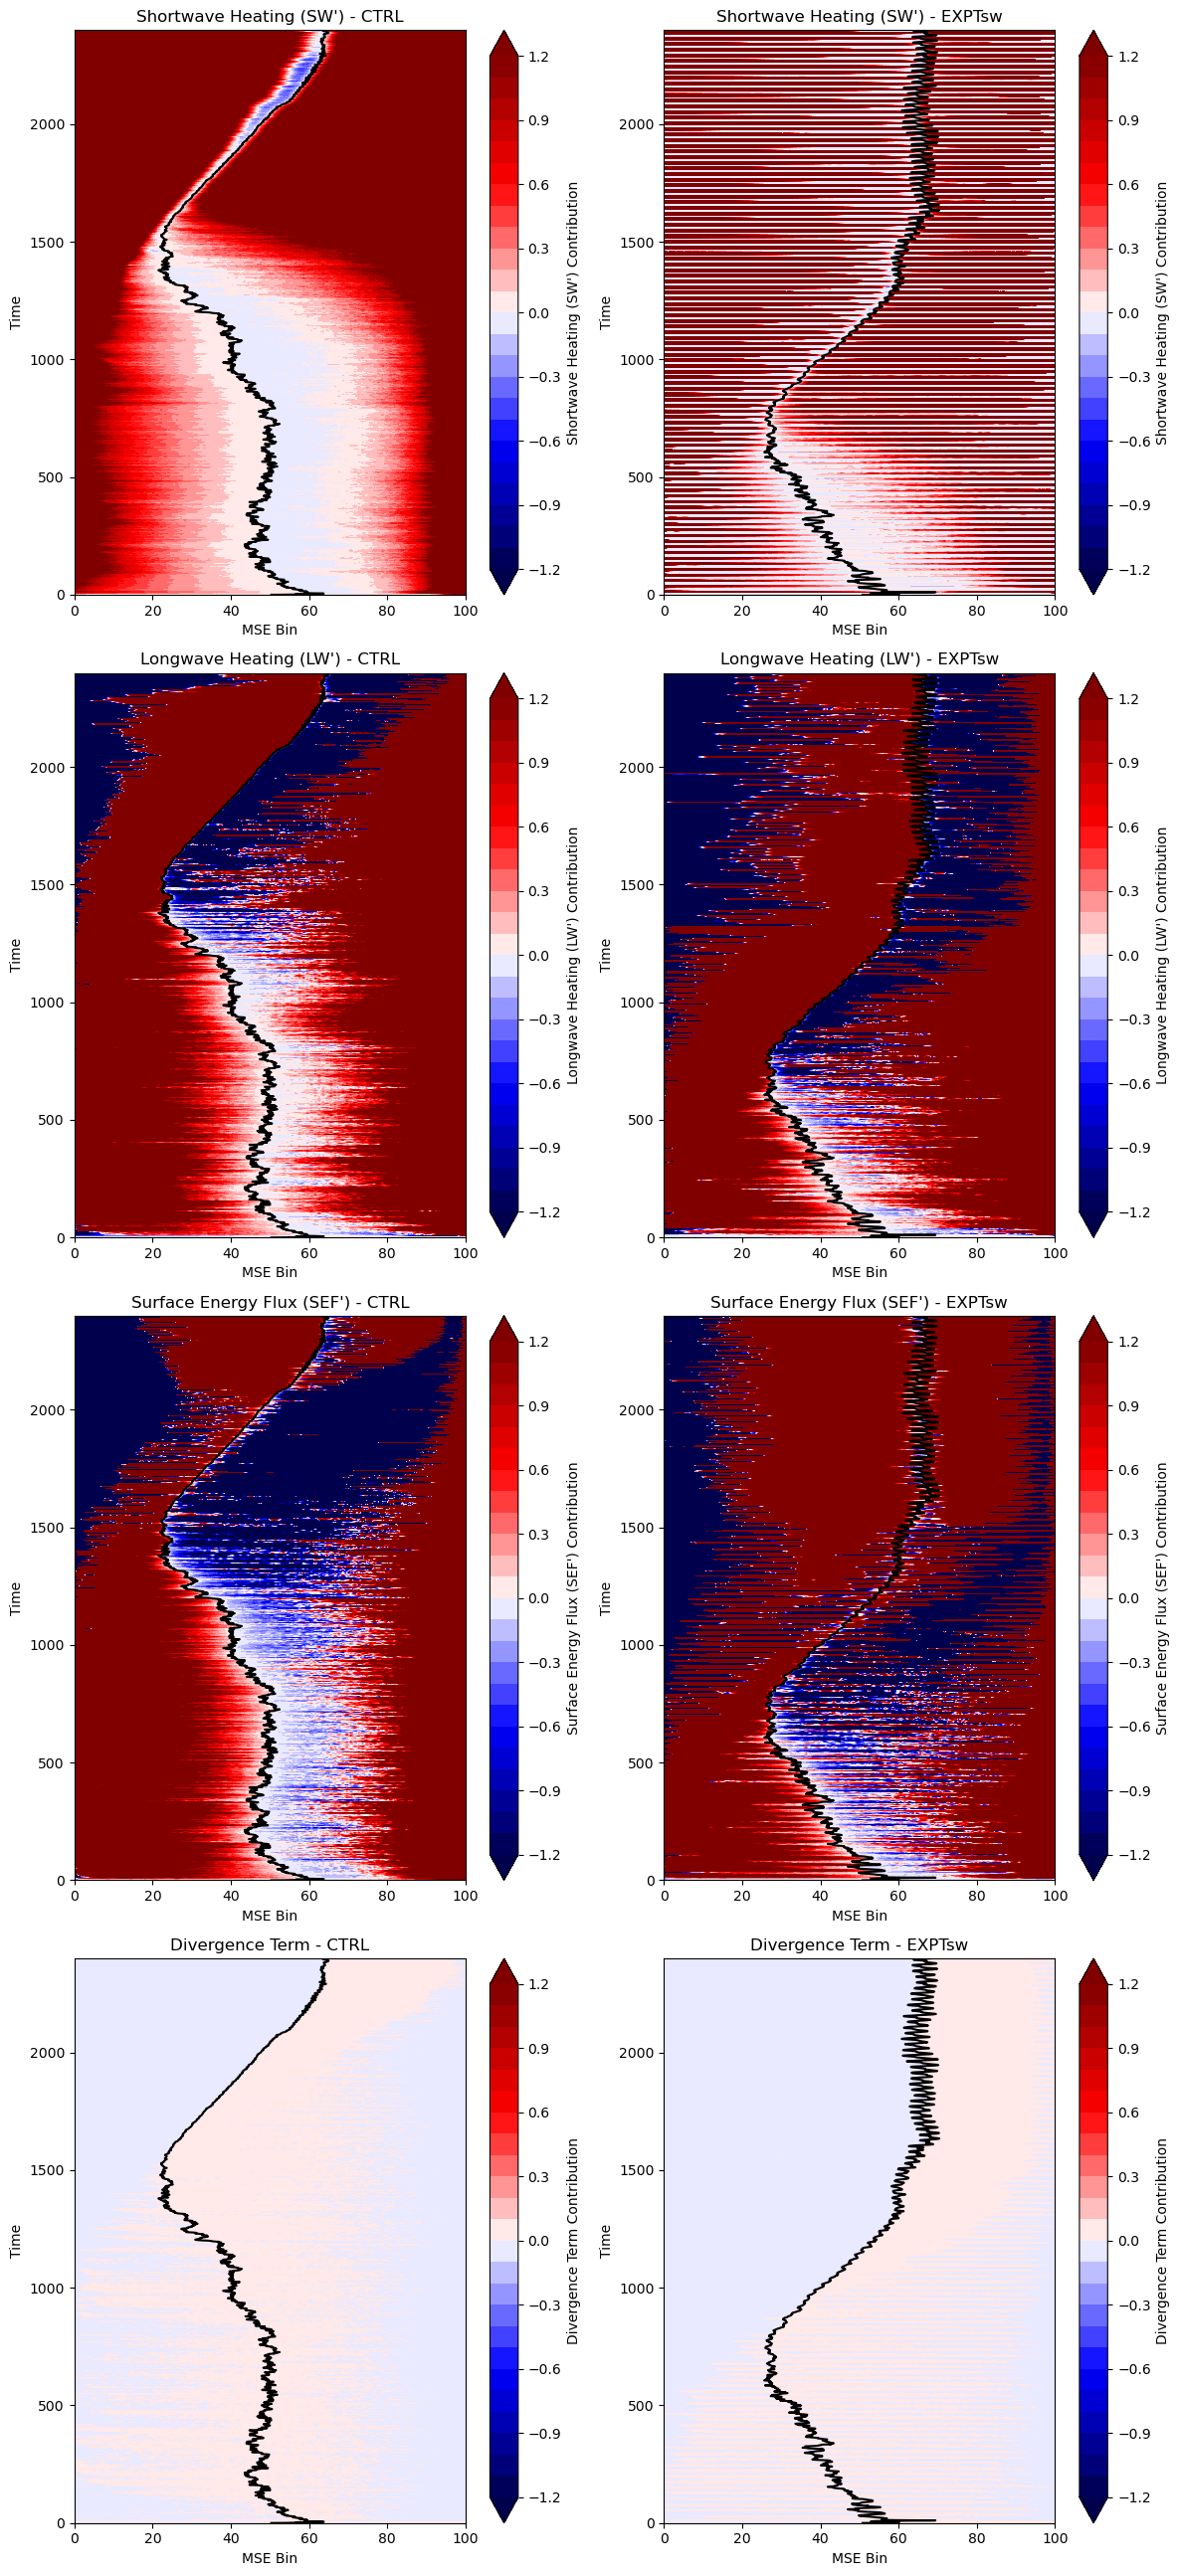

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define titles and colormaps
titles = ["Shortwave Heating (SW')", "Longwave Heating (LW')", "Surface Energy Flux (SEF')", "Divergence Term"]
cmaps = ["bwr", "bwr", "bwr", "bwr"]

# Define contour levels
clevs = np.linspace(-1.2, 1.2, 25)

# Create meshgrid
num_bins = contributions_CTRL[0].shape[1]
tn = contributions_CTRL[0].shape[0]
X, Y = np.meshgrid(np.linspace(0, num_bins, num_bins), np.linspace(0, tn, tn))

plt.figure(figsize=(12, 26))  # Adjusted figure size for 4x2 layout

for i, title in enumerate(titles):
    for j, (contributions, MSE_contrib, label) in enumerate(
        [(contributions_CTRL, MSE_CTRL, "CTRL"), 
         (contributions_EXPTsw, MSE_EXPTsw, "EXPTsw")]
    ):
        plt.subplot(4, 2, i * 2 + j + 1)

        # Filled contour plot
        contourf = plt.contourf(X, Y, contributions[i], levels=clevs, cmap="seismic", extend='both')

        # Superimpose zero contour of corresponding MSE variance
        plt.contour(X, Y, MSE_contrib, levels=[0], colors='black', linewidths=1.5)

        # Labels and title
        plt.colorbar(contourf, label=f"{title} Contribution")
        plt.xlabel('MSE Bin')
        plt.ylabel('Time')
        plt.title(f"{title} - {label}")

plt.tight_layout()
plt.show()


In [9]:
print("np.shape(MSE_contrib)=",np.shape(MSE_contrib))

np.shape(MSE_contrib)= (2400, 100)


In [10]:
import numpy as np

# Convert list to NumPy array
contributions_CTRL = np.array(contributions_CTRL)  # Shape (4, 2400, 10)
contributions_EXPTsw = np.array(contributions_EXPTsw)  # Shape (4, 2400, 10)
MSE_contrib_CTRL= np.array(MSE_CTRL)  # Shape (2400, 10)
MSE_contrib_EXPTsw= np.array(MSE_EXPTsw)  # Shape (2400, 10)

In [11]:
# np.shape(contributions_CTRL)
type(contributions_CTRL)

numpy.ndarray

In [12]:
# Define the range of days to average over
ndry=25 # Consider the driest 25 bins (percentile)

tstart=5
tend=20

In [13]:

# # Define the range of days to average over

# tstart=0 #Focusing on first 20 days, until when both simulations do not aggregate.
# tend=20

contributions_CTRL_daily_composite = np.mean(contributions_CTRL.reshape(4, 100, 24, 100)[:, tstart:tend, :, :], axis=1)
MSE_contrib_CTRL_daily_composite = np.mean(MSE_contrib_CTRL.reshape(100, 24, 100)[tstart:tend, :, :], axis=0)

# tstart=0
# tend=20

contributions_EXPTsw_daily_composite = np.mean(contributions_EXPTsw.reshape(4, 100, 24, 100)[:, tstart:tend, :, :], axis=1)
MSE_contrib_EXPTsw_daily_composite = np.mean(MSE_contrib_EXPTsw.reshape(100, 24, 100)[tstart:tend, :, :], axis=0)

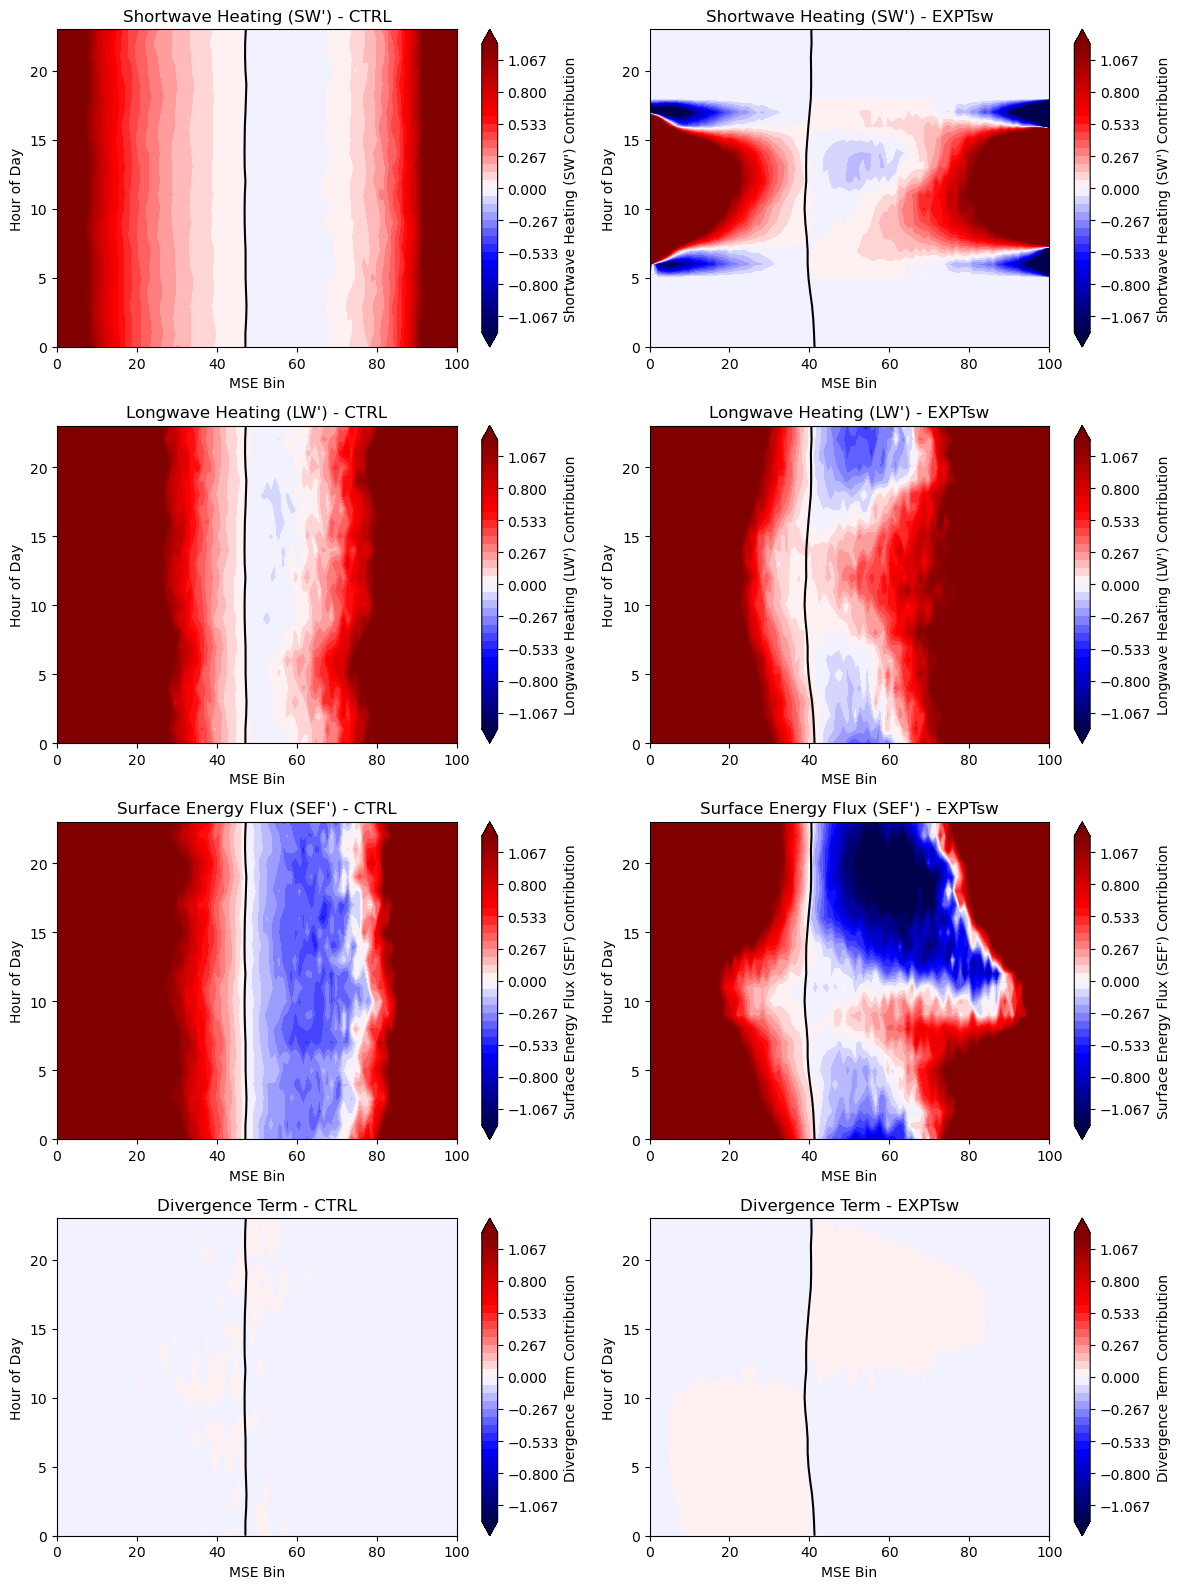

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Define titles and colormaps
titles = ["Shortwave Heating (SW')", "Longwave Heating (LW')", "Surface Energy Flux (SEF')", "Divergence Term"]
cmaps = ["seismic", "seismic", "seismic", "seismic"]

# Define contour levels
clevs = np.linspace(-1.2, 1.2, 37)

# Create meshgrid for daily cycle (24 hours)
num_bins = contributions_CTRL_daily_composite.shape[2]  # 10
X, Y = np.meshgrid(np.linspace(0, num_bins, num_bins), np.arange(24))  # Hours from 0 to 23

plt.figure(figsize=(12, 16))  # Adjusted figure size for 4x2 layout

for i, title in enumerate(titles):
    for j, (contributions, MSE_contrib, label) in enumerate(
        [(contributions_CTRL_daily_composite, MSE_contrib_CTRL_daily_composite, "CTRL"), 
         (contributions_EXPTsw_daily_composite, MSE_contrib_EXPTsw_daily_composite, "EXPTsw")]
    ):
        plt.subplot(4, 2, i * 2 + j + 1)

        # Filled contour plot
        contourf = plt.contourf(X, Y, contributions[i], levels=clevs, cmap="seismic", extend='both')

        # Superimpose zero contour of corresponding MSE variance
        plt.contour(X, Y, MSE_contrib, levels=[0], colors='black', linewidths=1.5)

        # Labels and title
        plt.colorbar(contourf, label=f"{title} Contribution")
        plt.xlabel('MSE Bin')
        plt.ylabel('Hour of Day')
        plt.title(f"{title} - {label}")

plt.tight_layout()
plt.show()


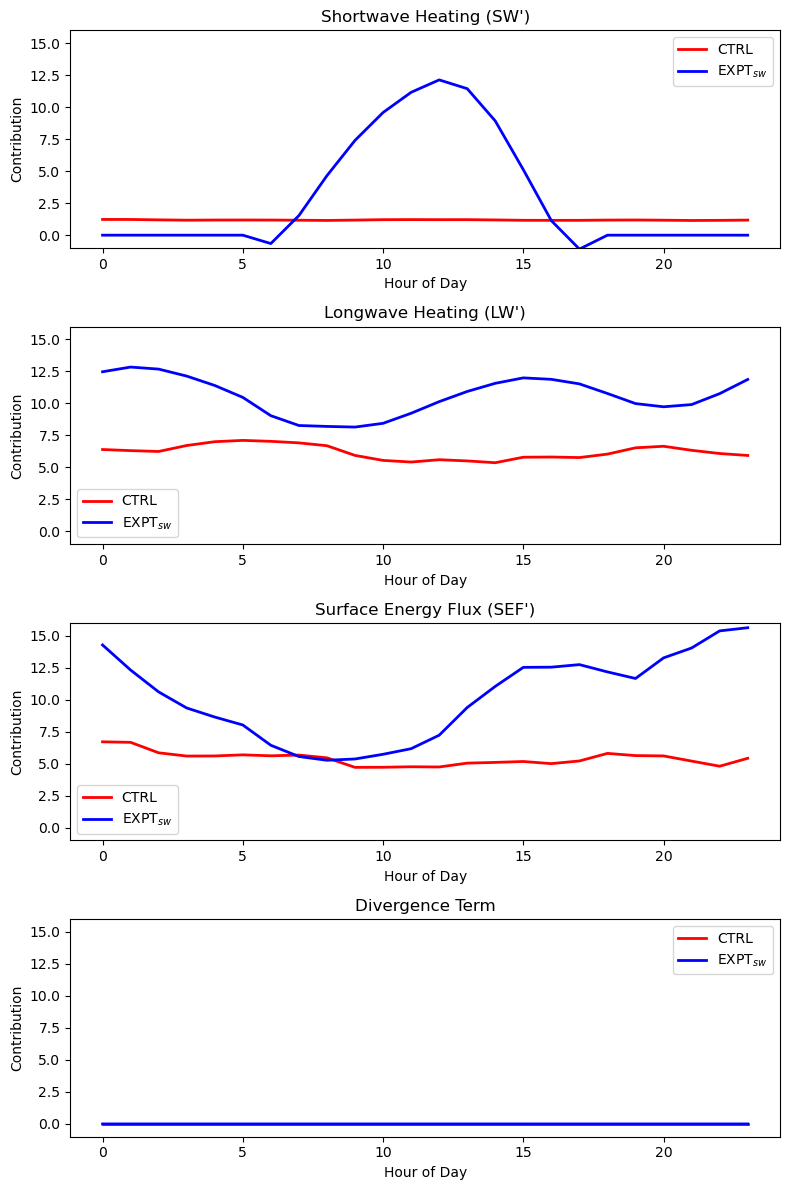

In [ ]:
#nbdime enabled


#contributions_CTRL.reshape(num_var=4, time=100, num_of_hours_of_day=24, num_bin=100)
contributions_CTRL_daily_composite = np.mean(contributions_CTRL.reshape(4, 100, 24, 100)[:, tstart:tend, :, :ndry], axis=(1, 3))
MSE_contrib_CTRL_daily_composite = np.mean(MSE_contrib_CTRL.reshape(100, 24, 100)[tstart:tend, :, :ndry], axis=(0, 2))

contributions_EXPTsw_daily_composite = np.mean(contributions_EXPTsw.reshape(4, 100, 24, 100)[:, tstart:tend, :, :ndry], axis=(1, 3))
MSE_contrib_EXPTsw_daily_composite = np.mean(MSE_contrib_EXPTsw.reshape(100, 24, 100)[tstart:tend, :, :ndry], axis=(0, 2))

#Plot the contributions.
import numpy as np
import matplotlib.pyplot as plt

# Define titles
titles = ["Shortwave Heating (SW')", "Longwave Heating (LW')", "Surface Energy Flux (SEF')", "Divergence Term"]

plt.figure(figsize=(8, 12))  # Adjust figure size for 4x1 layout

colors = ["red", "blue"]  # Red for CTRL, Blue for EXPTsw
labels = ["CTRL", "EXPT$_{sw}$"]

for i, title in enumerate(titles):
    plt.subplot(4, 1, i + 1)  # 4 rows, 1 column

    for contributions, color, label in zip(
        [contributions_CTRL_daily_composite, contributions_EXPTsw_daily_composite],
        colors,
        labels,
    ):
        # print(f"Shape of contributions[{i}] ({label}): {contributions[i].shape}")  # Debugging

        # Ensure we take the mean across the correct dimension
        if contributions[i].ndim > 1:  # If data has more than 1 dimension (e.g., (num_bins, 24))
            mean_contribution = np.mean(contributions[i], axis=0)  
            # std_contribution = np.std(contributions[i], axis=0)
        else:  # If it's already (24,)
            mean_contribution = contributions[i]  
            # std_contribution = np.zeros_like(mean_contribution)  # No variability info

        plt.plot(np.arange(24), mean_contribution, color=color, label=label, linewidth=2)
        # plt.fill_between(np.arange(24), mean_contribution - std_contribution, mean_contribution + std_contribution, 
        #                  color=color, alpha=0.2)  # Add shading for variability
    plt.ylim(-1.0, 16)  # Set y-axis limits for all subplots
    plt.xlabel("Hour of Day")
    plt.ylabel("Contribution")
    plt.title(f"{title}")
    plt.legend()

plt.tight_layout()
plt.show()


In [16]:
LW_CTRL = compute_var_diurnal("SAM6108_RCE_MC_20250311_256x256_CTRL_e7_rank40")
LW_EXPTsw = compute_var_diurnal("SAM6108_RCE_MC_20250311_256x256_EXPTsw_e8_rank50")

LW_CTRL_daily_composite = LW_CTRL.values[tstart*24:tend*24].reshape(-1, 24).mean(axis=0)
LW_EXPTsw_daily_composite = LW_EXPTsw.values[tstart*24:tend*24].reshape(-1, 24).mean(axis=0)

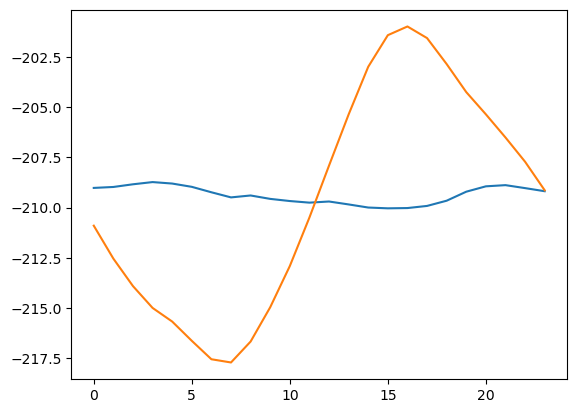

In [17]:
plt.plot(LW_CTRL_daily_composite)
plt.plot(LW_EXPTsw_daily_composite)

In [18]:
SOLIN_CTRL, SST_CTRL = compute_var_diurnal_1D("SAM6108_RCE_MC_20250311_256x256_CTRL_e7_rank40")
SOLIN_EXPTsw, SST_EXPTsw = compute_var_diurnal_1D("SAM6108_RCE_MC_20250311_256x256_EXPTsw_e8_rank50")

SOLIN_CTRL_daily_composite = SOLIN_CTRL.values[tstart*24:tend*24].reshape(-1, 24).mean(axis=0)
SST_CTRL_daily_composite = SST_CTRL.values[tstart*24:tend*24].reshape(-1, 24).mean(axis=0)

SOLIN_EXPTsw_daily_composite = SOLIN_EXPTsw.values[tstart*24:tend*24].reshape(-1, 24).mean(axis=0)
SST_EXPTsw_daily_composite = SST_EXPTsw.values[tstart*24:tend*24].reshape(-1, 24).mean(axis=0)

##Final beautified plot

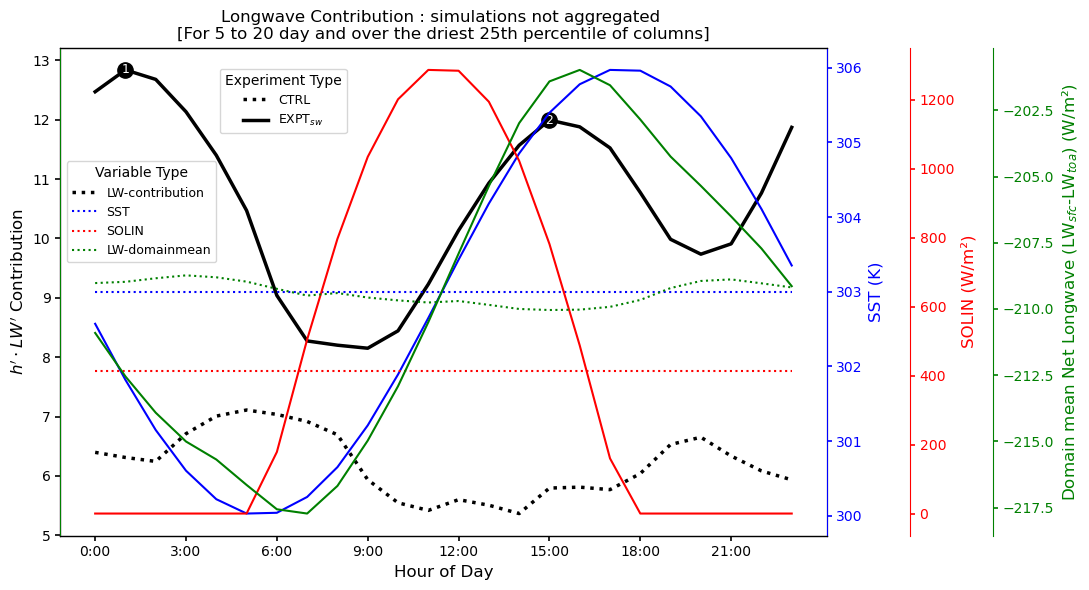

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

# Titles
titles = ["Longwave Contribution : simulations not aggregated \n[For "+str(tstart)+" to "+str(tend)+" day and over the driest "+str(ndry)+"th percentile of columns]"]

fig, ax1 = plt.subplots(figsize=(11, 6))  # Set figure size

# Global font settings (axis labels + ticks)
label_fontsize = 12
label_fontweight = "normal"
tick_fontsize = 10
tick_fontweight = "normal"

# Line thickness settings
linewidth_LW = 2.5  # Adjust for CTRL
linewidth_other = 1.5  # Adjust for EXPTsw

CTRL_l_style="dotted"
EXPTsw_l_style="solid"

# Select the second subplot (LW' - Longwave Heating)
title = titles[0]

contri_LW_CTRL=contributions_CTRL_daily_composite[1]
contri_LW_EXPT=contributions_EXPTsw_daily_composite[1]

# Plot contributions on the primary y-axis (LW')
lw_ctrl, = ax1.plot(np.arange(24), contri_LW_CTRL, 
                    color="black", linestyle=CTRL_l_style, linewidth=linewidth_LW)
lw_exptsw, = ax1.plot(np.arange(24), contri_LW_EXPT, 
                      color="black", linestyle=EXPTsw_l_style, linewidth=linewidth_LW)

# --- Add markers at first two maxima of EXPT ---
x = np.arange(24)
y = contri_LW_EXPT
maxima_indices = argrelextrema(y, np.greater)[0]

if len(maxima_indices) >= 2:
    for idx, num in zip(maxima_indices[:2], ["1", "2"]):
        ax1.plot(x[idx], y[idx], 'ko', markersize=11)  # Filled black circle
        ax1.text(x[idx], y[idx], num, color='white', fontsize=9, 
                 ha='center', va='center', fontweight='normal')

# --- Axes Labels ---
ax1.set_xlabel("Hour of Day", fontsize=label_fontsize, fontweight=label_fontweight)
ax1.set_ylabel(r"$h' \cdot LW'$ Contribution", fontsize=label_fontsize, fontweight=label_fontweight)
ax1.set_title(f"{title}", fontsize=label_fontsize, fontweight=label_fontweight)

# Set tick params for ax1
ax1.tick_params(axis="both", labelsize=tick_fontsize, width=1.2)
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_fontweight(tick_fontweight)

# --- Second y-axis (SST) ---
ax2 = ax1.twinx()
# ax2 -> blue
ax2.tick_params(axis='y', colors='blue')
ax2.yaxis.label.set_color('blue')
ax2.spines['right'].set_color('blue')   # if it's a twin axis
ax2.spines['left'].set_color('blue')    # if it's on the left

sst_ctrl, = ax2.plot(np.arange(24), SST_CTRL_daily_composite, 
                     color="blue", linestyle=CTRL_l_style, linewidth=linewidth_other)
sst_exptsw, = ax2.plot(np.arange(24), SST_EXPTsw_daily_composite, 
                       color="blue", linestyle=EXPTsw_l_style, linewidth=linewidth_other)

ax2.set_ylabel("SST (K)", fontsize=label_fontsize, fontweight=label_fontweight)
ax2.tick_params(axis="y", labelsize=tick_fontsize, colors="blue", width=1.2)
for label in ax2.get_yticklabels():
    label.set_fontweight(tick_fontweight)

# --- Third y-axis (SOLIN) ---
ax3 = ax1.twinx()
# ax3 -> red
ax3.tick_params(axis='y', colors='red')
ax3.yaxis.label.set_color('red')
ax3.spines['right'].set_color('red')
ax3.spines['left'].set_color('red')

ax3.spines["right"].set_position(("outward", 60))
solin_ctrl, = ax3.plot(np.arange(24), SOLIN_CTRL_daily_composite, 
                        color="red", linestyle=CTRL_l_style, linewidth=linewidth_other)
solin_exptsw, = ax3.plot(np.arange(24), SOLIN_EXPTsw_daily_composite, 
                          color="red", linestyle=EXPTsw_l_style, linewidth=linewidth_other)

ax3.set_ylabel("SOLIN (W/m²)", fontsize=label_fontsize, fontweight=label_fontweight)
ax3.tick_params(axis="y", labelsize=tick_fontsize, colors="red", width=1.2)
for label in ax3.get_yticklabels():
    label.set_fontweight(tick_fontweight)

# --- Fourth y-axis (LW-domainmean) ---
ax4 = ax1.twinx()
# ax4 -> green
ax4.tick_params(axis='y', colors='green')
ax4.yaxis.label.set_color('green')
ax4.spines['right'].set_color('green')
ax4.spines['left'].set_color('green')

ax4.spines["right"].set_position(("outward", 120))
LW_domainmean_ctrl, = ax4.plot(np.arange(24), LW_CTRL_daily_composite, 
                        color="g", linestyle=CTRL_l_style, linewidth=linewidth_other)
LW_domainmean_exptsw, = ax4.plot(np.arange(24), LW_EXPTsw_daily_composite, 
                          color="g", linestyle=EXPTsw_l_style, linewidth=linewidth_other)

ax4.set_ylabel("Domain mean Net Longwave (LW$_{sfc}$-LW$_{toa}$) (W/m²)", 
               fontsize=label_fontsize, fontweight=label_fontweight)
ax4.tick_params(axis="y", labelsize=tick_fontsize, colors="green", width=1.2)
for label in ax4.get_yticklabels():
    label.set_fontweight(tick_fontweight)

# --- Legends with manual positioning ---
legend1 = ax1.legend([lw_ctrl, sst_ctrl, solin_ctrl, LW_domainmean_ctrl], 
                     ["LW-contribution", "SST", "SOLIN", "LW-domainmean"], 
                     loc="upper left", bbox_to_anchor=(0.0, 0.78), 
                     title="Variable Type", fontsize=9, title_fontsize=10)

legend2 = ax1.legend([lw_ctrl, lw_exptsw], 
                     ["CTRL", "EXPT$_{sw}$"], 
                     loc="upper left", bbox_to_anchor=(0.20, 0.97), 
                     title="Experiment Type", fontsize=9, title_fontsize=10)

ax1.add_artist(legend1)  # Re-add first legend

# --- X-axis setup ---
xtick_labels = np.arange(0, 24, 3)
ax1.set_xticks(xtick_labels)
ax1.set_xticklabels([f"{int(x)}:00" for x in xtick_labels], 
                    fontsize=tick_fontsize, fontweight=tick_fontweight)

plt.tight_layout()

# Save
fig_directory='./'
figname="Figure_MSE_variance_Fig7_R2"
plt.savefig(f"{fig_directory}/{figname}.svg", format="svg", transparent=True, dpi=1200)
!rsvg-convert -f pdf -o {fig_directory}/{figname}.pdf {fig_directory}/{figname}.svg

plt.show()


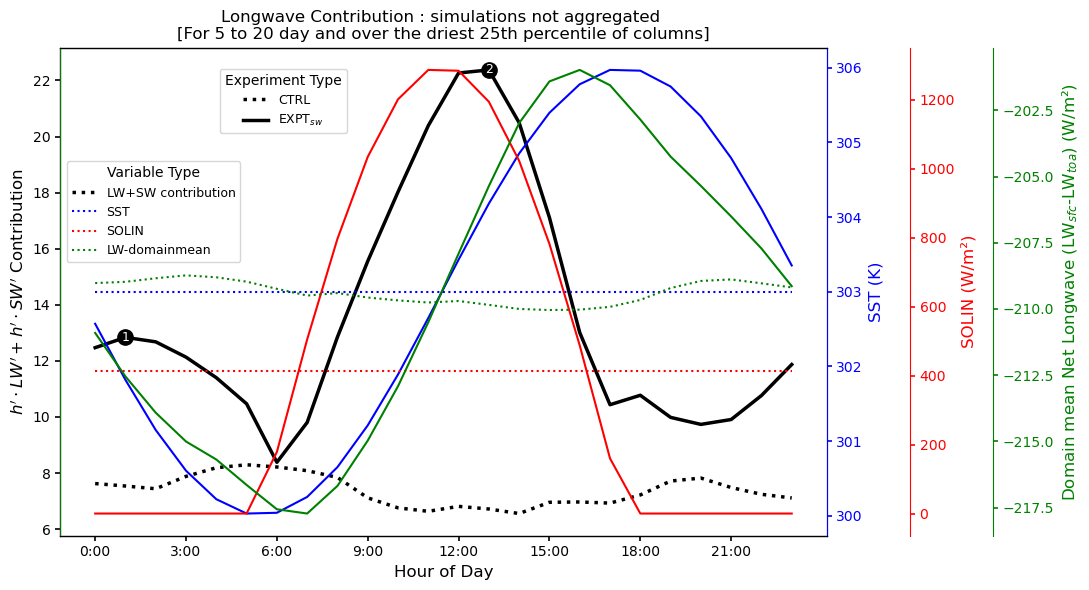

In [33]:
#Plotting LW+SW as suggested by the reviewer. 

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

# Titles
titles = ["Longwave Contribution : simulations not aggregated \n[For "+str(tstart)+" to "+str(tend)+" day and over the driest "+str(ndry)+"th percentile of columns]"]

fig, ax1 = plt.subplots(figsize=(11, 6))  # Set figure size

# Global font settings (axis labels + ticks)
label_fontsize = 12
label_fontweight = "normal"
tick_fontsize = 10
tick_fontweight = "normal"

# Line thickness settings
linewidth_LW = 2.5  # Adjust for CTRL
linewidth_other = 1.5  # Adjust for EXPTsw

CTRL_l_style="dotted"
EXPTsw_l_style="solid"

# Select the second subplot (LW' - Longwave Heating)
title = titles[0]

contri_LW_CTRL=contributions_CTRL_daily_composite[1]+contributions_CTRL_daily_composite[0]
contri_LW_EXPT=contributions_EXPTsw_daily_composite[1]+contributions_EXPTsw_daily_composite[0]

# Plot contributions on the primary y-axis (LW')
lw_ctrl, = ax1.plot(np.arange(24), contri_LW_CTRL, 
                    color="black", linestyle=CTRL_l_style, linewidth=linewidth_LW)
lw_exptsw, = ax1.plot(np.arange(24), contri_LW_EXPT, 
                      color="black", linestyle=EXPTsw_l_style, linewidth=linewidth_LW)

# --- Add markers at first two maxima of EXPT ---
x = np.arange(24)
y = contri_LW_EXPT
maxima_indices = argrelextrema(y, np.greater)[0]

if len(maxima_indices) >= 2:
    for idx, num in zip(maxima_indices[:2], ["1", "2"]):
        ax1.plot(x[idx], y[idx], 'ko', markersize=11)  # Filled black circle
        ax1.text(x[idx], y[idx], num, color='white', fontsize=9, 
                 ha='center', va='center', fontweight='normal')

# --- Axes Labels ---
ax1.set_xlabel("Hour of Day", fontsize=label_fontsize, fontweight=label_fontweight)
ax1.set_ylabel(r"$h' \cdot LW' + h' \cdot SW'$ Contribution", fontsize=label_fontsize, fontweight=label_fontweight)
ax1.set_title(f"{title}", fontsize=label_fontsize, fontweight=label_fontweight)

# Set tick params for ax1
ax1.tick_params(axis="both", labelsize=tick_fontsize, width=1.2)
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_fontweight(tick_fontweight)

# --- Second y-axis (SST) ---
ax2 = ax1.twinx()
# ax2 -> blue
ax2.tick_params(axis='y', colors='blue')
ax2.yaxis.label.set_color('blue')
ax2.spines['right'].set_color('blue')   # if it's a twin axis
ax2.spines['left'].set_color('blue')    # if it's on the left

sst_ctrl, = ax2.plot(np.arange(24), SST_CTRL_daily_composite, 
                     color="blue", linestyle=CTRL_l_style, linewidth=linewidth_other)
sst_exptsw, = ax2.plot(np.arange(24), SST_EXPTsw_daily_composite, 
                       color="blue", linestyle=EXPTsw_l_style, linewidth=linewidth_other)

ax2.set_ylabel("SST (K)", fontsize=label_fontsize, fontweight=label_fontweight)
ax2.tick_params(axis="y", labelsize=tick_fontsize, colors="blue", width=1.2)
for label in ax2.get_yticklabels():
    label.set_fontweight(tick_fontweight)

# --- Third y-axis (SOLIN) ---
ax3 = ax1.twinx()
# ax3 -> red
ax3.tick_params(axis='y', colors='red')
ax3.yaxis.label.set_color('red')
ax3.spines['right'].set_color('red')
ax3.spines['left'].set_color('red')

ax3.spines["right"].set_position(("outward", 60))
solin_ctrl, = ax3.plot(np.arange(24), SOLIN_CTRL_daily_composite, 
                        color="red", linestyle=CTRL_l_style, linewidth=linewidth_other)
solin_exptsw, = ax3.plot(np.arange(24), SOLIN_EXPTsw_daily_composite, 
                          color="red", linestyle=EXPTsw_l_style, linewidth=linewidth_other)

ax3.set_ylabel("SOLIN (W/m²)", fontsize=label_fontsize, fontweight=label_fontweight)
ax3.tick_params(axis="y", labelsize=tick_fontsize, colors="red", width=1.2)
for label in ax3.get_yticklabels():
    label.set_fontweight(tick_fontweight)

# --- Fourth y-axis (LW-domainmean) ---
ax4 = ax1.twinx()
# ax4 -> green
ax4.tick_params(axis='y', colors='green')
ax4.yaxis.label.set_color('green')
ax4.spines['right'].set_color('green')
ax4.spines['left'].set_color('green')

ax4.spines["right"].set_position(("outward", 120))
LW_domainmean_ctrl, = ax4.plot(np.arange(24), LW_CTRL_daily_composite, 
                        color="g", linestyle=CTRL_l_style, linewidth=linewidth_other)
LW_domainmean_exptsw, = ax4.plot(np.arange(24), LW_EXPTsw_daily_composite, 
                          color="g", linestyle=EXPTsw_l_style, linewidth=linewidth_other)

ax4.set_ylabel("Domain mean Net Longwave (LW$_{sfc}$-LW$_{toa}$) (W/m²)", 
               fontsize=label_fontsize, fontweight=label_fontweight)
ax4.tick_params(axis="y", labelsize=tick_fontsize, colors="green", width=1.2)
for label in ax4.get_yticklabels():
    label.set_fontweight(tick_fontweight)

# --- Legends with manual positioning ---
legend1 = ax1.legend([lw_ctrl, sst_ctrl, solin_ctrl, LW_domainmean_ctrl], 
                     ["LW+SW contribution", "SST", "SOLIN", "LW-domainmean"], 
                     loc="upper left", bbox_to_anchor=(0.0, 0.78), 
                     title="Variable Type", fontsize=9, title_fontsize=10)

legend2 = ax1.legend([lw_ctrl, lw_exptsw], 
                     ["CTRL", "EXPT$_{sw}$"], 
                     loc="upper left", bbox_to_anchor=(0.20, 0.97), 
                     title="Experiment Type", fontsize=9, title_fontsize=10)

ax1.add_artist(legend1)  # Re-add first legend

# --- X-axis setup ---
xtick_labels = np.arange(0, 24, 3)
ax1.set_xticks(xtick_labels)
ax1.set_xticklabels([f"{int(x)}:00" for x in xtick_labels], 
                    fontsize=tick_fontsize, fontweight=tick_fontweight)

plt.tight_layout()

# Save
fig_directory='./'
figname="Figure_MSE_variance_Fig7_R2_LWplusSW"
plt.savefig(f"{fig_directory}/{figname}.svg", format="svg", transparent=True, dpi=1200)
!rsvg-convert -f pdf -o {fig_directory}/{figname}.pdf {fig_directory}/{figname}.svg

plt.show()


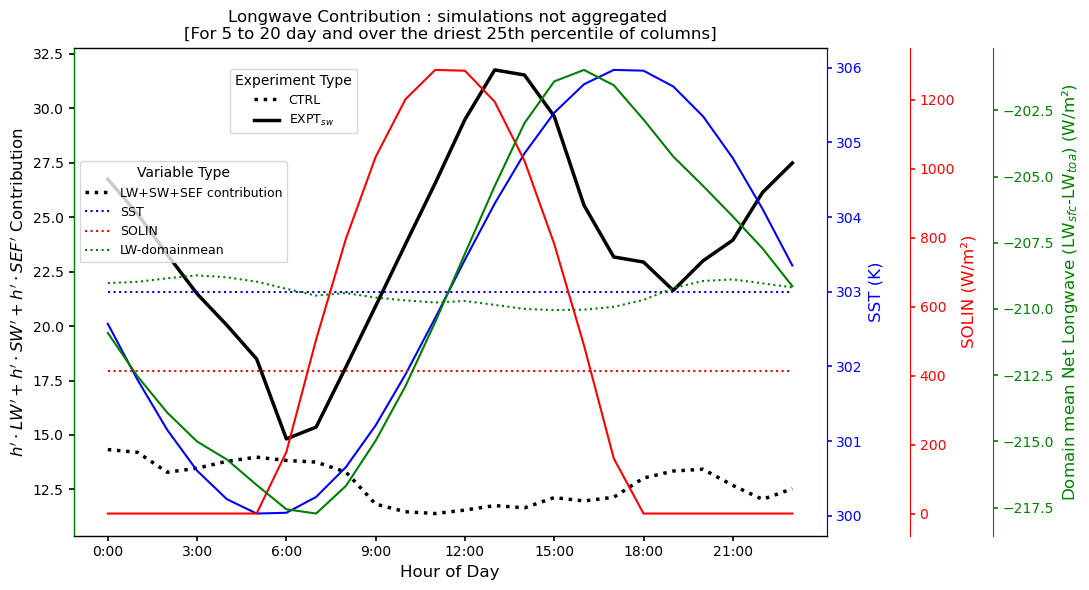

In [34]:
#Plotting LW+SW+SEF as suggested by the reviewer. 

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

# Titles
titles = ["Longwave Contribution : simulations not aggregated \n[For "+str(tstart)+" to "+str(tend)+" day and over the driest "+str(ndry)+"th percentile of columns]"]

fig, ax1 = plt.subplots(figsize=(11, 6))  # Set figure size

# Global font settings (axis labels + ticks)
label_fontsize = 12
label_fontweight = "normal"
tick_fontsize = 10
tick_fontweight = "normal"

# Line thickness settings
linewidth_LW = 2.5  # Adjust for CTRL
linewidth_other = 1.5  # Adjust for EXPTsw

CTRL_l_style="dotted"
EXPTsw_l_style="solid"

# Select the second subplot (LW' - Longwave Heating)
title = titles[0]

contri_LW_CTRL=contributions_CTRL_daily_composite[2]+contributions_CTRL_daily_composite[1]+contributions_CTRL_daily_composite[0]
contri_LW_EXPT=contributions_EXPTsw_daily_composite[2]+contributions_EXPTsw_daily_composite[1]+contributions_EXPTsw_daily_composite[0]

# Plot contributions on the primary y-axis (LW')
lw_ctrl, = ax1.plot(np.arange(24), contri_LW_CTRL, 
                    color="black", linestyle=CTRL_l_style, linewidth=linewidth_LW)
lw_exptsw, = ax1.plot(np.arange(24), contri_LW_EXPT, 
                      color="black", linestyle=EXPTsw_l_style, linewidth=linewidth_LW)

# --- Add markers at first two maxima of EXPT ---
x = np.arange(24)
y = contri_LW_EXPT
maxima_indices = argrelextrema(y, np.greater)[0]

if len(maxima_indices) >= 2:
    for idx, num in zip(maxima_indices[:2], ["1", "2"]):
        ax1.plot(x[idx], y[idx], 'ko', markersize=11)  # Filled black circle
        ax1.text(x[idx], y[idx], num, color='white', fontsize=9, 
                 ha='center', va='center', fontweight='normal')

# --- Axes Labels ---
ax1.set_xlabel("Hour of Day", fontsize=label_fontsize, fontweight=label_fontweight)
ax1.set_ylabel(r"$h' \cdot LW' + h' \cdot SW' + h' \cdot SEF'$ Contribution", fontsize=label_fontsize, fontweight=label_fontweight)
ax1.set_title(f"{title}", fontsize=label_fontsize, fontweight=label_fontweight)

# Set tick params for ax1
ax1.tick_params(axis="both", labelsize=tick_fontsize, width=1.2)
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_fontweight(tick_fontweight)

# --- Second y-axis (SST) ---
ax2 = ax1.twinx()
# ax2 -> blue
ax2.tick_params(axis='y', colors='blue')
ax2.yaxis.label.set_color('blue')
ax2.spines['right'].set_color('blue')   # if it's a twin axis
ax2.spines['left'].set_color('blue')    # if it's on the left

sst_ctrl, = ax2.plot(np.arange(24), SST_CTRL_daily_composite, 
                     color="blue", linestyle=CTRL_l_style, linewidth=linewidth_other)
sst_exptsw, = ax2.plot(np.arange(24), SST_EXPTsw_daily_composite, 
                       color="blue", linestyle=EXPTsw_l_style, linewidth=linewidth_other)

ax2.set_ylabel("SST (K)", fontsize=label_fontsize, fontweight=label_fontweight)
ax2.tick_params(axis="y", labelsize=tick_fontsize, colors="blue", width=1.2)
for label in ax2.get_yticklabels():
    label.set_fontweight(tick_fontweight)

# --- Third y-axis (SOLIN) ---
ax3 = ax1.twinx()
# ax3 -> red
ax3.tick_params(axis='y', colors='red')
ax3.yaxis.label.set_color('red')
ax3.spines['right'].set_color('red')
ax3.spines['left'].set_color('red')

ax3.spines["right"].set_position(("outward", 60))
solin_ctrl, = ax3.plot(np.arange(24), SOLIN_CTRL_daily_composite, 
                        color="red", linestyle=CTRL_l_style, linewidth=linewidth_other)
solin_exptsw, = ax3.plot(np.arange(24), SOLIN_EXPTsw_daily_composite, 
                          color="red", linestyle=EXPTsw_l_style, linewidth=linewidth_other)

ax3.set_ylabel("SOLIN (W/m²)", fontsize=label_fontsize, fontweight=label_fontweight)
ax3.tick_params(axis="y", labelsize=tick_fontsize, colors="red", width=1.2)
for label in ax3.get_yticklabels():
    label.set_fontweight(tick_fontweight)

# --- Fourth y-axis (LW-domainmean) ---
ax4 = ax1.twinx()
# ax4 -> green
ax4.tick_params(axis='y', colors='green')
ax4.yaxis.label.set_color('green')
ax4.spines['right'].set_color('green')
ax4.spines['left'].set_color('green')

ax4.spines["right"].set_position(("outward", 120))
LW_domainmean_ctrl, = ax4.plot(np.arange(24), LW_CTRL_daily_composite, 
                        color="g", linestyle=CTRL_l_style, linewidth=linewidth_other)
LW_domainmean_exptsw, = ax4.plot(np.arange(24), LW_EXPTsw_daily_composite, 
                          color="g", linestyle=EXPTsw_l_style, linewidth=linewidth_other)

ax4.set_ylabel("Domain mean Net Longwave (LW$_{sfc}$-LW$_{toa}$) (W/m²)", 
               fontsize=label_fontsize, fontweight=label_fontweight)
ax4.tick_params(axis="y", labelsize=tick_fontsize, colors="green", width=1.2)
for label in ax4.get_yticklabels():
    label.set_fontweight(tick_fontweight)

# --- Legends with manual positioning ---
legend1 = ax1.legend([lw_ctrl, sst_ctrl, solin_ctrl, LW_domainmean_ctrl], 
                     ["LW+SW+SEF contribution", "SST", "SOLIN", "LW-domainmean"], 
                     loc="upper left", bbox_to_anchor=(0.0, 0.78), 
                     title="Variable Type", fontsize=9, title_fontsize=10)

legend2 = ax1.legend([lw_ctrl, lw_exptsw], 
                     ["CTRL", "EXPT$_{sw}$"], 
                     loc="upper left", bbox_to_anchor=(0.20, 0.97), 
                     title="Experiment Type", fontsize=9, title_fontsize=10)

ax1.add_artist(legend1)  # Re-add first legend

# --- X-axis setup ---
xtick_labels = np.arange(0, 24, 3)
ax1.set_xticks(xtick_labels)
ax1.set_xticklabels([f"{int(x)}:00" for x in xtick_labels], 
                    fontsize=tick_fontsize, fontweight=tick_fontweight)

plt.tight_layout()

# Save
fig_directory='./'
figname="Figure_MSE_variance_Fig7_R2_LWplusSWplusSEF"
plt.savefig(f"{fig_directory}/{figname}.svg", format="svg", transparent=True, dpi=1200)
!rsvg-convert -f pdf -o {fig_directory}/{figname}.pdf {fig_directory}/{figname}.svg

plt.show()


In [21]:
# tstart=5
# tend=20
LWc=contributions_CTRL.reshape(4, 100, 24, 100)[1, tstart:tend, :, :ndry].mean(axis=2)
LWe=contributions_EXPTsw.reshape(4, 100, 24, 100)[1, tstart:tend, :, :ndry].mean(axis=2)
np.shape(LWc)

(15, 24)

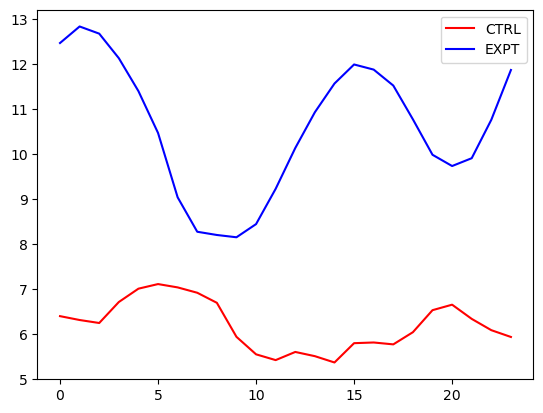

In [23]:
plt.plot(LWc.mean(axis=0),color='r',label='CTRL')
plt.plot(LWe.mean(axis=0),color='b',label='EXPT')
plt.legend()

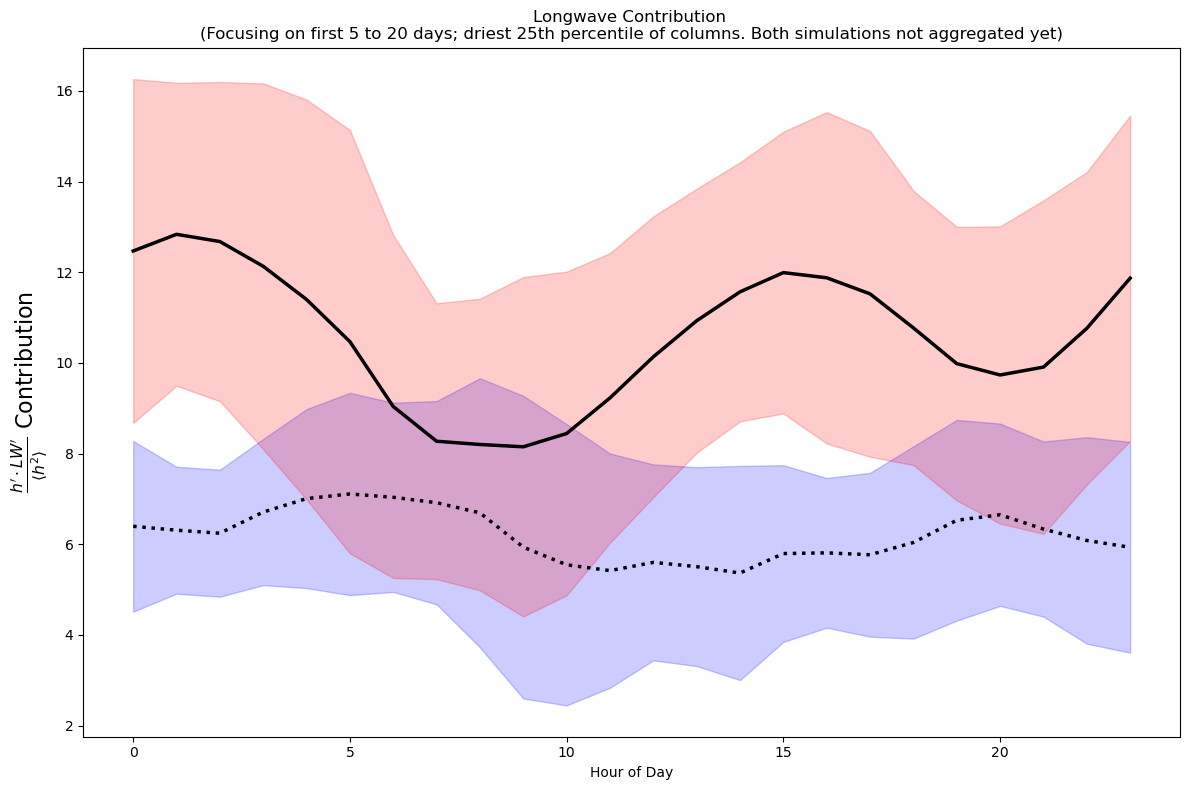

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Titles
titles = ["Longwave Contribution \n(Focusing on first "+str(tstart)+" to "+str(tend)+" days; driest "+str(ndry)+"th percentile of columns. Both simulations not aggregated yet)"]

fig, ax1 = plt.subplots(figsize=(12, 8))  # Set figure size

# Line thickness settings
linewidth_LW = 2.5  # Adjust for CTRL
linewidth_other = 1.5  # Adjust for EXPTsw

CTRL_l_style="dotted"
EXPTsw_l_style="solid"

# Select the second subplot (LW' - Longwave Heating)
title = titles[0]  # "Longwave Heating (LW')"

LWc=contributions_CTRL.reshape(4, 100, 24, 100)[1, tstart:tend, :, :ndry].mean(axis=2).T
LWe=contributions_EXPTsw.reshape(4, 100, 24, 100)[1, tstart:tend, :, :ndry].mean(axis=2).T

# Compute mean and standard deviation along axis=1
mean_LWc = np.mean(LWc, axis=1)
std_LWc = np.std(LWc, axis=1)

mean_LWe = np.mean(LWe, axis=1)
std_LWe = np.std(LWe, axis=1)

# X-axis values (e.g., 24 hours of the day)
x = np.arange(24)

# Plot contributions on the primary y-axis (LW')
lw_ctrl, = ax1.plot(np.arange(24), mean_LWc, 
                    color="black", linestyle=CTRL_l_style, linewidth=linewidth_LW)
ax1.fill_between(x, mean_LWc - std_LWc, mean_LWc + std_LWc, color="blue", alpha=0.2)


lw_exptsw, = ax1.plot(np.arange(24), mean_LWe, 
                      color="black", linestyle=EXPTsw_l_style, linewidth=linewidth_LW)
ax1.fill_between(x, mean_LWe - std_LWe, mean_LWe + std_LWe, color="red", alpha=0.2)

ax1.set_xlabel("Hour of Day")
ax1.set_ylabel(r"$\frac{h' \cdot LW'}{\langle h^2 \rangle}$ Contribution", fontsize=16)
ax1.set_title(f"{title}")




# Add the first legend back to the plot
# ax1.add_artist(legend1)

plt.tight_layout()

#Saving figure
# fig_directory='./'
# figname="Figure_MSE_variance_supp"

# plt.savefig(''+str(fig_directory)+'/'+str(figname)+'.svg', format="svg",transparent=True, dpi=1200)
# !rsvg-convert -f pdf -o {fig_directory}/{figname}.pdf {fig_directory}/{figname}.svg

plt.show()

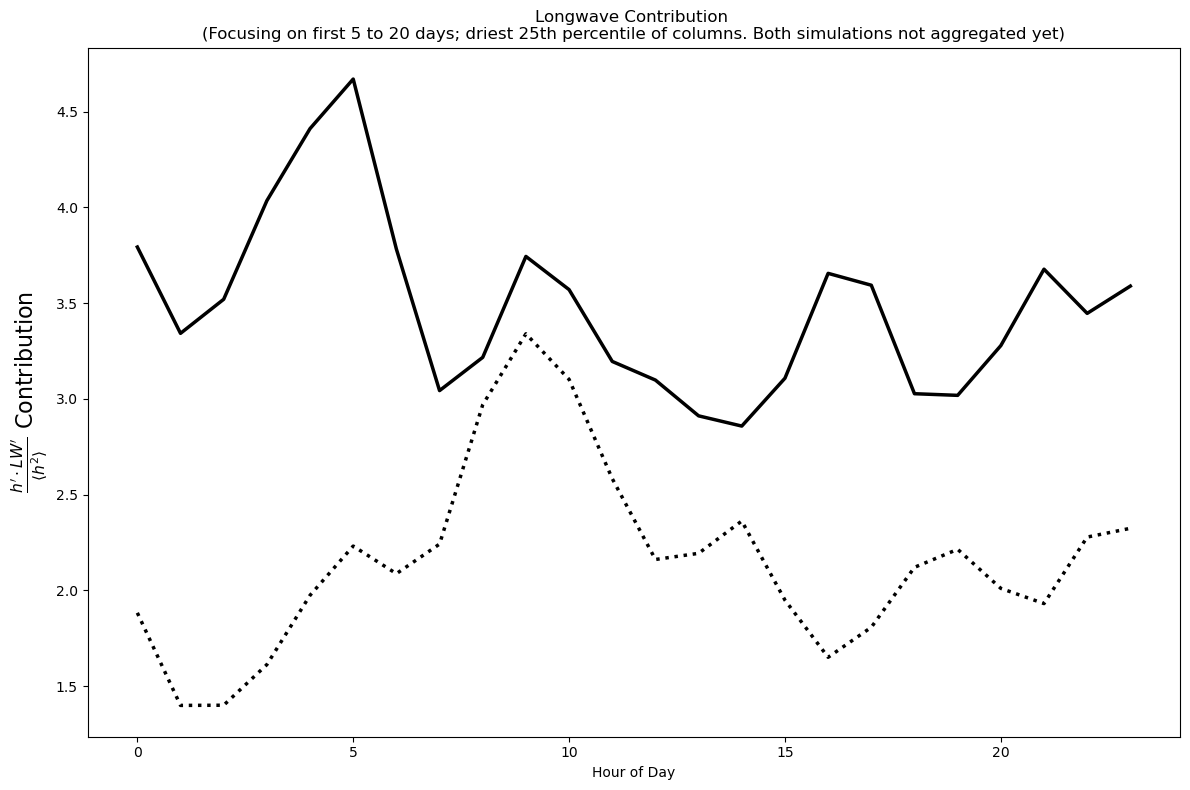

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Titles
titles = ["Longwave Contribution \n(Focusing on first "+str(tstart)+" to "+str(tend)+" days; driest "+str(ndry)+"th percentile of columns. Both simulations not aggregated yet)"]

fig, ax1 = plt.subplots(figsize=(12, 8))  # Set figure size

# Line thickness settings
linewidth_LW = 2.5  # Adjust for CTRL
linewidth_other = 1.5  # Adjust for EXPTsw

CTRL_l_style="dotted"
EXPTsw_l_style="solid"

# Select the second subplot (LW' - Longwave Heating)
title = titles[0]  # "Longwave Heating (LW')"

LWc=contributions_CTRL.reshape(4, 100, 24, 100)[1, tstart:tend, :, :ndry].mean(axis=2).T
LWe=contributions_EXPTsw.reshape(4, 100, 24, 100)[1, tstart:tend, :, :ndry].mean(axis=2).T

# Compute mean and standard deviation along axis=1
mean_LWc = np.mean(LWc, axis=1)
std_LWc = np.std(LWc, axis=1)

mean_LWe = np.mean(LWe, axis=1)
std_LWe = np.std(LWe, axis=1)

# X-axis values (e.g., 24 hours of the day)
x = np.arange(24)

# Plot contributions on the primary y-axis (LW')
lw_ctrl, = ax1.plot(np.arange(24), std_LWc, 
                    color="black", linestyle=CTRL_l_style, linewidth=linewidth_LW)

lw_exptsw, = ax1.plot(np.arange(24), std_LWe, 
                      color="black", linestyle=EXPTsw_l_style, linewidth=linewidth_LW)

ax1.set_xlabel("Hour of Day")
ax1.set_ylabel(r"$\frac{h' \cdot LW'}{\langle h^2 \rangle}$ Contribution", fontsize=16)
ax1.set_title(f"{title}")




# Add the first legend back to the plot
# ax1.add_artist(legend1)

plt.tight_layout()

#Saving figure
# fig_directory='./'
# figname="Figure_MSE_variance_supp"

# plt.savefig(''+str(fig_directory)+'/'+str(figname)+'.svg', format="svg",transparent=True, dpi=1200)
# !rsvg-convert -f pdf -o {fig_directory}/{figname}.pdf {fig_directory}/{figname}.svg

plt.show()